In [2]:
!pip install datasets evaluate pymorphy2 sacrebleu rouge_score -qq

In [3]:
from datasets import load_dataset, DatasetDict
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, pipeline

import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger
import wandb
from evaluate import load
import pymorphy2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [13]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [17]:
model_name = "google/flan-t5-small"

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, trust_remote_code=True).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
ds = load_dataset("sentence-transformers/yahoo-answers", "question-answer-pair")

README.md:   0%|          | 0.00/6.36k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/297M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/681164 [00:00<?, ? examples/s]

In [14]:
ds

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 681164
    })
})

In [7]:
ds_splitted = ds['train'].train_test_split(test_size=0.1, seed=42)

In [8]:
ds_splitted

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 613047
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 68117
    })
})

In [9]:
ds_train, ds_test = ds_splitted['train'], ds_splitted['test']

In [10]:
ds_test_valid = ds_test.train_test_split(test_size=0.3, seed=42)

In [11]:
ds_test, ds_valid = ds_test_valid['train'], ds_test_valid['test']

In [12]:
ds_train, ds_test, ds_valid

(Dataset({
     features: ['question', 'answer'],
     num_rows: 613047
 }),
 Dataset({
     features: ['question', 'answer'],
     num_rows: 47681
 }),
 Dataset({
     features: ['question', 'answer'],
     num_rows: 20436
 }))

In [16]:
lengths_question = []
for text in tqdm(ds_train['question']):
  lengths_question.append(len(tokenizer(text)['input_ids']))

  0%|          | 0/613047 [00:00<?, ?it/s]

In [ ]:
lengths_answer = []
for text in tqdm(ds_train['answer']):
  lengths_answer.append(len(tokenizer(text)['input_ids']))

  0%|          | 0/613047 [00:00<?, ?it/s]

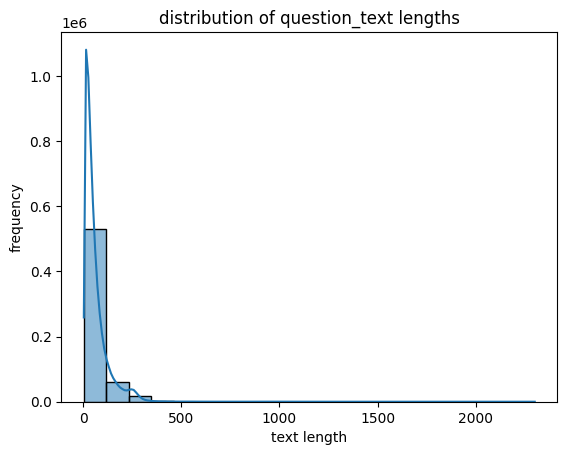

In [15]:
lengths_df_question = pd.Series(lengths_question)
sterdges_value = int(np.log2(len(ds_train['question'])) + 1)
sns.histplot(data=lengths_df_question, kde=True, bins=sterdges_value)

plt.title('distribution of question_text lengths')
plt.xlabel('text length')
plt.ylabel('frequency')

plt.show();

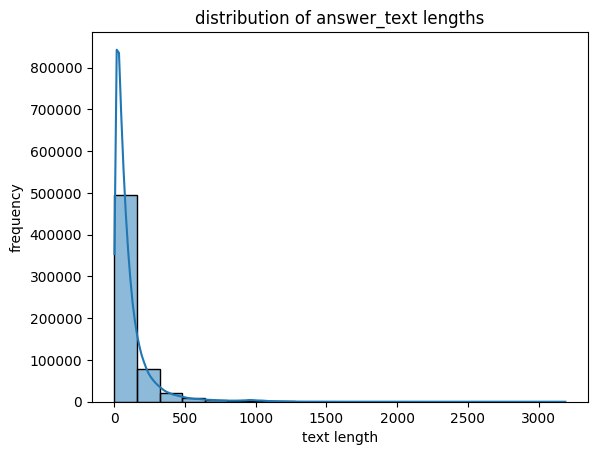

In [16]:
lengths_df_answer = pd.Series(lengths_answer)
sterdges_value = int(np.log2(len(ds_train['answer'])) + 1)
sns.histplot(data=lengths_df_answer, kde=True, bins=sterdges_value)

plt.title('distribution of answer_text lengths')
plt.xlabel('text length')
plt.ylabel('frequency')

plt.show();

In [17]:
lengths_df_question.quantile(0.97) # therefore, 512 is appropriate for us

239.0

In [18]:
lengths_df_answer.quantile(0.97) # therefore, 512 is appropriate for us

481.0

In [15]:
def preprocess_func(examples):
  texts = [f'Answer the question: {q}' for q in examples['question']] # for batched=True
  targets = examples['answer']
  inputs = tokenizer(texts, max_length=512, padding='max_length', truncation=True)
  labels = tokenizer(targets, max_length=512, padding="max_length", truncation=True)
  inputs['labels'] = labels['input_ids']

  return inputs

In [18]:
tokenized_train_dataset = ds_train.map(preprocess_func, batched=True)
tokenized_test_dataset = ds_test.map(preprocess_func, batched=True)
tokenized_valid_dataset = ds_valid.map(preprocess_func, batched=True)

Map:   0%|          | 0/613047 [00:00<?, ? examples/s]

Map:   0%|          | 0/47681 [00:00<?, ? examples/s]

Map:   0%|          | 0/20436 [00:00<?, ? examples/s]

In [19]:
tokenized_train_dataset.set_format(type='torch')
tokenized_test_dataset.set_format(type='torch')
tokenized_valid_dataset.set_format(type='torch')

In [20]:
tokenized_train_dataset

Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 613047
})

In [21]:
train_dataloader = DataLoader(tokenized_train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=16, shuffle=False)
valid_dataloader = DataLoader(tokenized_valid_dataset, batch_size=16, shuffle=False)

In [22]:
for batch in train_dataloader:
  print(batch['input_ids'].shape)
  print(batch['attention_mask'].shape)
  print(batch['labels'].shape)
  break

torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])


## Check base model quality

In [21]:
PAD = tokenizer.pad_token_id
PAD

0

In [22]:
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)
morph = pymorphy2.MorphAnalyzer()

def lemmatize(text):
    return ' '.join([morph.parse(word)[0].normal_form for word in text.split()])

In [22]:
bleu = load('sacrebleu')
rouge = load('rouge')

running_loss = 0.0
bleu_scores = []
rouge_scores = {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}
n_samples = 0

for idx, batch in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
  inputs = batch['input_ids'].to(device)
  attention_mask = batch['attention_mask'].to(device)
  targets = batch['labels'].to(device)

  targets_text = [
    lemmatize(tokenizer.decode(target, skip_special_tokens=True, clean_up_tokenization_spaces=True))
    for target in targets
  ]

  with torch.no_grad():
    # inputs.shape -> (batch_size, seq_len, emb_size)
    # attention_mask.shape -> (batch_size, seq_len, emb_size)
    # targets.shape -> (batch_size, seq_len, emb_size)
    outputs = model(inputs, attention_mask=attention_mask, labels=targets)
    logits = outputs.logits
    loss = loss_fn(logits.view(-1, logits.size(-1)), targets.view(-1))
    running_loss += loss.item()

    predictions = torch.argmax(logits, dim=-1)
    pred_text = [
        lemmatize(tokenizer.decode(pred, skip_special_tokens=True, clean_up_tokenization_spaces=True))
        for pred in predictions
    ]

    bleu_result = bleu.compute(predictions=pred_text, references=[[target] for target in targets_text])
    bleu_scores.append(bleu_result['score'])

    rouge_result = rouge.compute(predictions=pred_text, references=targets_text)
    for key in rouge_scores:
      rouge_scores[key] += rouge_result[key]


  n_samples += len(targets)

average_loss = running_loss / len(valid_dataloader)
average_rouge = {key: value / n_samples for key, value in rouge_scores.items()}
average_bleu = sum(bleu_scores) / len(bleu_scores)

print(f'validation ce_loss: {average_loss}')
print(f'ROUGE score: {average_rouge}')
print(f'BLEU score: {average_bleu}')

  0%|          | 0/1278 [00:00<?, ?it/s]

validation ce_loss: 3.6477231290978445
ROUGE score: {'rouge1': 0.016541793563373906, 'rouge2': 0.0031634467809112696, 'rougeL': 0.012222605466443145}
BLEU score: 3.2759145159014387


validation ce_loss: 3.6477231290978445
ROUGE score: {'rouge1': 0.016541793563373906, 'rouge2': 0.0031634467809112696, 'rougeL': 0.012222605466443145}
BLEU score: 3.2759145159014387

## Model fine-tuning stage

In [23]:
wandb_logger = WandbLogger(
    project="flan_t5_yahoo_answers_fine_tune",
    name="flan_t5_10000_steps",
    log_model="all"
)

wandb.init(project=wandb_logger.version, name=wandb_logger.name)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [24]:
rouge = load('rouge')
bleu = load('sacrebleu')

def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
  bleu_result = bleu.compute(predictions=decoded_preds, references=decoded_labels)

  metrics = {
      'bleu': bleu_result['score'],
      'rouge1': rouge_result['rouge1'],
      'rouge2': rouge_result['rouge2'],
      'rougeL': rouge_result['rougeL']
  }

  wandb.log(metrics)
    
  return metrics

In [25]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [27]:
training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    evaluation_strategy='steps',
    learning_rate=5e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    #num_train_epochs=3,
    max_steps=10000,
    predict_with_generate=True,
    generation_max_length=768,
    logging_dir='./logs',
    logging_steps=10000,
    logging_strategy='steps',
    save_steps=10000,
    save_strategy='steps',
    load_best_model_at_end=True,
    metric_for_best_model='rouge1',
    greater_is_better=True,
    report_to="wandb"
)

eval_dataset=tokenized_test_dataset.select(random.sample(range(len(tokenized_test_dataset)-10), k=1000))
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=eval_dataset, # only 1000, because we don't have enough time (generation, for bleu and rouge, is too time consuming)
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer.train()

In [ ]:
trainer.save_model('./finetuned_flan_t5_small_10000_steps')

## Push trained model to hub

In [ ]:
from huggingface_hub import login

login(token='your_hf_token')

In [ ]:
trainer.push_to_hub("GlebNoNeGolubin/flan_t5_yahoo_ansers_10000_steps")

## Check trained model quality

In [75]:
bleu = load('sacrebleu')
rouge = load('rouge')

running_loss = 0.0
bleu_scores = []
rouge_scores = {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}
n_samples = 0

for idx, batch in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
  inputs = batch['input_ids'].to(device)
  attention_mask = batch['attention_mask'].to(device)
  targets = batch['labels'].to(device)

  targets_text = [
    lemmatize(tokenizer.decode(target, skip_special_tokens=True, clean_up_tokenization_spaces=True))
    for target in targets
  ]

  with torch.no_grad():
    # inputs.shape -> (batch_size, seq_len, emb_size)
    # attention_mask.shape -> (batch_size, seq_len, emb_size)
    # targets.shape -> (batch_size, seq_len, emb_size)
    outputs = model(inputs, attention_mask=attention_mask, labels=targets)
    logits = outputs.logits
    loss = loss_fn(logits.view(-1, logits.size(-1)), targets.view(-1))
    running_loss += loss.item()

    predictions = torch.argmax(logits, dim=-1)
    pred_text = [
        lemmatize(tokenizer.decode(pred, skip_special_tokens=True, clean_up_tokenization_spaces=True))
        for pred in predictions
    ]

    bleu_result = bleu.compute(predictions=pred_text, references=[[target] for target in targets_text])
    bleu_scores.append(bleu_result['score'])

    rouge_result = rouge.compute(predictions=pred_text, references=targets_text)
    for key in rouge_scores:
      rouge_scores[key] += rouge_result[key]


  n_samples += len(targets)

average_loss = running_loss / len(valid_dataloader)
average_rouge = {key: value / n_samples for key, value in rouge_scores.items()}
average_bleu = sum(bleu_scores) / len(bleu_scores)

print(f'validation ce_loss: {average_loss}')
print(f'ROUGE score: {average_rouge}')
print(f'BLEU score: {average_bleu}')

  0%|          | 0/1278 [00:00<?, ?it/s]

validation ce_loss: 3.3502273546511394
ROUGE score: {'rouge1': 0.022846319871780273, 'rouge2': 0.0047586625413359685, 'rougeL': 0.017483581876328473}
BLEU score: 7.145252283093193


validation ce_loss: 3.3502273546511394
ROUGE score: {'rouge1': 0.022846319871780273, 'rouge2': 0.0047586625413359685, 'rougeL': 0.017483581876328473}
BLEU score: 7.145252283093193

## Running trained model in terminal script 

In [27]:
def main():
    device = ('cuda' if torch.cuda.is_available() else 'cpu')
    pipe = pipeline("text2text-generation", model="GlebNoNeGolubin/results", device=device)

    print("Type 'stop' to quit.")

    while True:
        user_input = input("\nYour question: ")

        if user_input.lower() == 'exit':
            print("Exiting... Goodbye!")
            break

        try:
            output = pipe(
                user_input,
                max_length=768,
                num_return_sequences=1,
                repetition_penalty=2.0,
                temperature=0.9,
                do_sample=True
            )

            generated_text = output[0]['generated_text']
            print(f"Generated output: {generated_text}")
        except Exception as e:
            print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

Type 'stop' to quit.



Your question:  hello


Generated output: hello i dont know you im sorry



Your question:  apple


Generated output: apple is a great thing. it can be used as a sweet tea and has an abundance of flavors to make the whole taste better



Your question:  what do you think about the Earth?


Generated output: Earth and the earth's planetary surface is very similar. It takes us on to develop more than we could possibly see, but it can be much easier with an approach.



Your question:  what is the difference between me and you?


Generated output: People don't like each other, they are just stupid. They have a lot of problems trying to make things better than what everyone else says and that it works when you can say nothing when not being honest with them in their way (even though you may be happy about this even though it was an easy one!).nPeople tend not accept themselves as friends or go out for the occasional date...thats my favorite thing I know-then who is going through different trouble now and then...and she seems so lucky that any step of her life does take time off the road while there to help others....they all need someone around him which makes me feel good at something and let his friendship heal


KeyboardInterrupt: Interrupted by user